In [1]:
%load_ext autoreload
%autoreload 

import time
import os
import numpy as np

import torch
import torch.nn as nn

import pickle
import pandas as pd
from sklearn.model_selection import train_test_split

from torch_geometric.data import Data
from torch_geometric.utils import subgraph, to_undirected

from torch_geometric.loader import DataLoader
from torch_geometric.utils import subgraph


In [2]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

dataset = torch.load('./data/EllipticBTC.pt')
dataset.edge_index = to_undirected(dataset.edge_index)
dataset.y = dataset.y.to(torch.int64)
dataset.x = dataset.x.to(torch.float32)
dataset.train_mask = (dataset.step<=30)

In [3]:
from torch_geometric.loader import NeighborLoader

dataset_train, dataset_val, dataset_test = [], [], []
train_day = 30
train_num = 0

for i in dataset.step.unique():
    idx = torch.where(dataset.step==i)[0]
    x = dataset.x[idx]
    y = dataset.y[idx]
    edge_index, _= subgraph(idx, dataset.edge_index, relabel_nodes=True)
    daily_graph = Data(x=x, edge_index=edge_index, y=y)
    daily_graph.labeled_mask = (y<2) 
    if i<=train_day:
        dataset_train.append(daily_graph)
        train_num += daily_graph.num_nodes

    elif i>train_day and i<=train_day+4:
        dataset_val.append(daily_graph)
    elif i>train_day+4:
        dataset_test.append(daily_graph)

kwargs = {'batch_size': 1024}
train_loader = NeighborLoader(dataset, input_nodes=dataset.train_mask, num_neighbors=[25, 10], shuffle=True, **kwargs)
val_loader = DataLoader(dataset_val, batch_size=1, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [4]:
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score

def store_metrics(pred_scores, target_labels):

  # calculate metrics
  pred_labels = pred_scores.argmax(axis=1)
  accuracy = accuracy_score(target_labels, pred_labels)
  f1macro = f1_score(target_labels, pred_labels,average='macro')
  aucroc = roc_auc_score(target_labels, pred_scores[:,-1])
  
  return accuracy, f1macro, aucroc

In [5]:
from torch_geometric.nn import GINConv, Linear

class GINNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super().__init__()
        nn1 = nn.Sequential(Linear(input_dim, 4*hidden_dim),
                            nn.ReLU(),Linear(4*hidden_dim, 4*hidden_dim))
        self.conv1 = GINConv(nn1, train_eps=True)
        self.batchnorm1 = nn.BatchNorm1d(4*hidden_dim)
        
        nn2 = nn.Sequential(Linear(4*hidden_dim,  4*hidden_dim),
                            nn.ReLU(),Linear(4*hidden_dim, 4*hidden_dim))
        self.conv2 = GINConv(nn2, train_eps=True)
        self.batchnorm2 = nn.BatchNorm1d(4*hidden_dim)
        
        nn3 = nn.Sequential(Linear(4*hidden_dim,  hidden_dim),
                            nn.ReLU(),Linear(hidden_dim, hidden_dim))
        self.conv3 = GINConv(nn3, train_eps=True)
        self.batchnorm3 = nn.BatchNorm1d(hidden_dim)

        self.fc1 = Linear(hidden_dim, hidden_dim)
        self.batchnorm4 = nn.BatchNorm1d(hidden_dim)

        self.fc2 = Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x, edge_index):
        x = self.batchnorm1(self.conv1(x, edge_index)).relu()
        x = self.batchnorm2(self.conv2(x, edge_index)).relu()
        x = self.batchnorm3(self.conv3(x, edge_index)).relu()
        x = self.batchnorm4(self.fc1(x)).relu()
        x = self.fc2(x)
        return x

In [6]:
import torch.nn.functional as F
from sklearn.metrics import f1_score
from torch_geometric.loader import NeighborLoader

num_features = 165
num_classes = 2
REPEAT = 5

In [7]:
from GUIDE.guide import GUIDE
args = {}
args['dataname'] = 'BTC'
args['shards_number'] = 20
args['device'] = device
partations_fast = []
for gi in range(len(dataset_train)):
    args['gi'] = gi    
    GUIDE_Fast = GUIDE(edge_indexs=dataset_train[gi].edge_index, labels=dataset_train[gi].y, k=args['shards_number'])
    p1 = GUIDE_Fast.fit(method='Fast', alpha_=1e-3)
    p1_saved = GUIDE_Fast.subgraph_repair(x = dataset_train[gi].x, REPAIR_METHOD='None', PATH='checkpoints/',DATA_NAME='{}'.format(args['dataname']), MULTI_GRAPH = args['gi'])
    savename = p1_saved.DPATH.split('partid')[0]+p1_saved.method+'_saved.pt'
    torch.save(p1_saved, savename)
    partations_fast.append(p1_saved)


method:Fast, running time:2.9964282512664795, balance:-0.0282994923857868, fairness:-0.03710165642105656
method:Fast, running time:0.7101492881774902, balance:-0.018661972502587547, fairness:-0.017959522711865544
method:Fast, running time:1.6143028736114502, balance:-0.018969940429834995, fairness:-0.02584167144402047
method:Fast, running time:1.3181746006011963, balance:-0.03510451538793529, fairness:-0.028765169649278832
method:Fast, running time:1.9872691631317139, balance:-0.017962665325155263, fairness:-0.020999533884280892
method:Fast, running time:0.7873451709747314, balance:-0.02758779895944648, fairness:-0.01609607432161777
method:Fast, running time:1.3922512531280518, balance:-0.020006613756613757, fairness:-0.024590085672135942
method:Fast, running time:0.7822873592376709, balance:-0.032230198316464974, fairness:-0.03731471834655304
method:Fast, running time:1.0260179042816162, balance:-0.041873498188199, fairness:-0.028875383358511458
method:Fast, running time:1.87779235839

In [9]:
from GUIDE.kernel_vector import PyramidMatchVector

gis_keys_graph = {}
pm_kernel = PyramidMatchVector()

for gi in range(len(dataset_train)):
    gis_keys_graph[gi] = {}
    for part_id in range(args['shards_number']):
        loadname = partations_fast[gi].DPATH.replace('partid', 'part'+str(part_id))
        sub_graph = torch.load(loadname)
        gis_keys_graph[gi][part_id] = sub_graph
        # kernel feature extraction for further use
        subg_kfea = pm_kernel.parse_input([sub_graph.edge_index.cpu()])
        savekfean = loadname.replace('subgraphs', 'subgkfeas').replace('.pt', '_PM'+'.pt')
        os.makedirs(os.path.dirname(savekfean), exist_ok=True)
        torch.save(subg_kfea, savekfean)
        partations_fast[gi].FPATH = savekfean.replace('part'+str(part_id), 'partid')
        # model save path
        savemodeln = loadname.replace('subgraphs', 'submodels').replace('.pt', '_'+ 'GINNet' +'.pt').replace('part'+str(part_id), 'partid')
        savemodeln = savemodeln.split('graph')[0] + 'model_part' + savemodeln.split('_part')[1]
        partations_fast[gi].MPATH = savemodeln.replace('part'+str(part_id), 'partid')

In [10]:
import os
import torch.nn.functional as F

args['num_features'] = num_features
args['num_classes'] = num_classes
results_Fast = {
    'acc' : np.zeros((16, REPEAT)),
    'f1macro' : np.zeros((16, REPEAT)),
    'aucroc' : np.zeros((16, REPEAT))
}

for repeat in range(REPEAT):
    for part_id in p1_saved.shards_ids.keys():
        # submodel training
        start = time.time()
        submodel = GINNet(input_dim=args['num_features'],
                    output_dim=args['num_classes']).to(args['device'])

        optimizer = torch.optim.Adam(
            submodel.parameters(), lr=0.01, weight_decay=1e-5)
        for epoch in range(1, 201):
            submodel.train()
            for gi in range(len(dataset_train)):
                sub_graph = gis_keys_graph[gi][part_id]
                sub_graph = sub_graph.to(device)
                labels = sub_graph.y[sub_graph.y < 2]
                if labels.sum() > 0:
                    weight = (labels == 0).sum().item() / labels.sum().item()
                else:
                    weight = 1.0
                optimizer.zero_grad()
                out = submodel(sub_graph.x, sub_graph.edge_index)[
                    sub_graph.train_mask]
                loss = F.cross_entropy(out[torch.where(sub_graph.y < 2)[
                    0]], labels, weight=torch.tensor([1., weight], device=device))

                loss.backward()
                optimizer.step()

        submodel.to('cpu')
        sub_graph = sub_graph.to('cpu')
        savemodeln = partations_fast[gi].MPATH.replace('partid', 'part'+str(part_id))
        os.makedirs(os.path.dirname(savemodeln), exist_ok=True)
        torch.save(submodel.state_dict(), savemodeln)
        del submodel, sub_graph, optimizer, out, loss

    preds, targets = [], []
    for day, data in enumerate(test_loader):
        pm_kernel = PyramidMatchVector()
        subgt_kfea = pm_kernel.parse_input([data.edge_index.cpu()])
        subg_kfea = []
        subouts = []
        for part_id in p1_saved.shards_ids.keys():
            for gi in range(len(dataset_train)):
                loadname = partations_fast[gi].FPATH.replace('partid', 'part'+str(part_id))
                subg_kfea += torch.load(loadname)

            submodel = GINNet(input_dim=args['num_features'],
                        output_dim=args['num_classes']).to(args['device'])
            savemodeln = partations_fast[gi].MPATH.replace('partid', 'part'+str(part_id))
            submodel.load_state_dict(torch.load(savemodeln))
            submodel.eval()
            subout = torch.softmax(submodel(data.x.to(args['device']), data.edge_index.to(args['device'])), dim=1)
            if 'labeled_mask' in data:
                subout = subout[data.labeled_mask]

            subouts.append(subout.detach().to('cpu'))
            submodel.to('cpu')
            del submodel, subout

        suboutTensor = torch.stack(subouts)

        daily_weights = pm_kernel.kernel_similarity(subgt_kfea, subg_kfea)
        daily_weights = torch.tensor(daily_weights).to(torch.float32).reshape(len(p1_saved.shards_ids.keys()), -1).mean(dim=-1)
        saveweightn = partations_fast[gi].MPATH.replace('partid/submodels/','').replace('model_partid', f'day{day}_weight')
        os.makedirs(os.path.dirname(saveweightn), exist_ok=True)
        torch.save(daily_weights, saveweightn)

        weights = F.softmax(daily_weights, dim=0)
        weighted_pred = torch.tensordot(suboutTensor, weights, dims=([0], [0]))

        if 'labeled_mask' in data:
            target_labels = data.y[data.labeled_mask].detach().cpu().numpy()
        else:
            target_labels = data.y.detach().cpu().numpy()
        
        test_acc, test_f1macro, test_aucroc= store_metrics(weighted_pred.detach().cpu().numpy(), target_labels)
        print("pred day {} test acc: {:.4f} - test f1macro: {:.4f} - test roc: {:.4f} ".format(day,
            test_acc, test_f1macro, test_aucroc))
        results_Fast['acc'][day, repeat] = test_acc
        results_Fast['f1macro'][day, repeat] = test_f1macro
        results_Fast['aucroc'][day, repeat] = test_aucroc
        preds.append(weighted_pred.detach().cpu().numpy())
        targets.append(target_labels)

    pred_all = np.concatenate(preds, axis=0)
    targets_all = np.concatenate(targets, axis=0)
    test_acc, test_f1macro, test_aucroc= store_metrics(pred_all, targets_all)
    print("final test acc: {:.4f} - test f1macro: {:.4f} - test roc: {:.4f}".format(test_acc, test_f1macro, test_aucroc))
    results_Fast['acc'][-1, repeat] = test_acc
    results_Fast['f1macro'][-1, repeat] = test_f1macro
    results_Fast['aucroc'][-1, repeat] = test_aucroc

pred day 0 test acc: 0.9597 - test f1macro: 0.9052 - test roc: 0.9524 
pred day 1 test acc: 0.9737 - test f1macro: 0.6471 - test roc: 0.8559 
pred day 2 test acc: 0.9418 - test f1macro: 0.7210 - test roc: 0.8712 
pred day 3 test acc: 0.8796 - test f1macro: 0.6837 - test roc: 0.9069 
pred day 4 test acc: 0.9298 - test f1macro: 0.6547 - test roc: 0.8800 
pred day 5 test acc: 0.9207 - test f1macro: 0.6501 - test roc: 0.7899 
pred day 6 test acc: 0.9240 - test f1macro: 0.7173 - test roc: 0.8830 
pred day 7 test acc: 0.9545 - test f1macro: 0.8619 - test roc: 0.9321 
pred day 8 test acc: 0.9788 - test f1macro: 0.4947 - test roc: 0.5926 
pred day 9 test acc: 0.9604 - test f1macro: 0.4899 - test roc: 0.4965 
pred day 10 test acc: 0.9885 - test f1macro: 0.4971 - test roc: 0.5232 
pred day 11 test acc: 0.9958 - test f1macro: 0.4989 - test roc: 0.8303 
pred day 12 test acc: 0.9728 - test f1macro: 0.4931 - test roc: 0.6425 
pred day 13 test acc: 0.9236 - test f1macro: 0.4801 - test roc: 0.5759 
pr

In [11]:
from GUIDE.guide import GUIDE
args = {}
args['dataname'] = 'BTC'
args['shards_number'] = 20
args['device'] = device
partations_sr = []
for gi in range(len(dataset_train)):
    args['gi'] = gi    
    GUIDE_SR = GUIDE(edge_indexs=dataset_train[gi].edge_index, labels=dataset_train[gi].y, k=args['shards_number'])
    p1 = GUIDE_SR.fit(method='SR', alpha_=1e-3, beta_=1e-2)
    p1_saved = GUIDE_SR.subgraph_repair(x = dataset_train[gi].x, REPAIR_METHOD='None', PATH='checkpoints/',DATA_NAME='{}'.format(args['dataname']), MULTI_GRAPH = args['gi'])
    savename = p1_saved.DPATH.split('partid')[0]+p1_saved.method+'_saved.pt'
    torch.save(p1_saved, savename)
    partations_sr.append(p1_saved)

from GUIDE.kernel_vector import PyramidMatchVector

gis_keys_graph = {}
pm_kernel = PyramidMatchVector()

for gi in range(len(dataset_train)):
    gis_keys_graph[gi] = {}
    for part_id in range(args['shards_number']):
        loadname = partations_sr[gi].DPATH.replace('partid', 'part'+str(part_id))
        sub_graph = torch.load(loadname)
        gis_keys_graph[gi][part_id] = sub_graph
        # kernel feature extraction for further use
        subg_kfea = pm_kernel.parse_input([sub_graph.edge_index.cpu()])
        savekfean = loadname.replace('subgraphs', 'subgkfeas').replace('.pt', '_PM'+'.pt')
        os.makedirs(os.path.dirname(savekfean), exist_ok=True)
        torch.save(subg_kfea, savekfean)
        partations_sr[gi].FPATH = savekfean.replace('part'+str(part_id), 'partid')
        # model save path
        savemodeln = loadname.replace('subgraphs', 'submodels').replace('.pt', '_'+ 'GINNet' +'.pt').replace('part'+str(part_id), 'partid')
        savemodeln = savemodeln.split('graph')[0] + 'model_part' + savemodeln.split('_part')[1]
        partations_sr[gi].MPATH = savemodeln.replace('part'+str(part_id), 'partid')


0.05850253807106599 0.028184831228491535 -0.05
method:SR, running time:5.063861131668091, balance:-0.05850253807106599, fairness:-0.028184831228491535
0.03428697250258755 0.023382415518472026 -0.05
method:SR, running time:2.4854180812835693, balance:-0.03428697250258755, fairness:-0.023382415518472026
0.049161758042591756 0.0329169410755436 -0.05
method:SR, running time:4.557128667831421, balance:-0.049161758042591756, fairness:-0.0329169410755436
0.04850693727322754 0.027024201191545826 -0.05
method:SR, running time:3.3759682178497314, balance:-0.04850693727322754, fairness:-0.027024201191545826
0.05612229719138156 0.03466286831399842 -0.05
method:SR, running time:4.798261404037476, balance:-0.05612229719138156, fairness:-0.03466286831399842
0.050369685767097966 0.022120079355213533 -0.05
method:SR, running time:2.3335487842559814, balance:-0.050369685767097966, fairness:-0.022120079355213533
0.05314153338235522 0.03424189503128232 -0.05
method:SR, running time:3.9917097091674805, bal

In [12]:

import os
import torch.nn.functional as F

args['num_features'] = num_features
args['num_classes'] = num_classes
results_SR = {
    'acc' : np.zeros((16, REPEAT)),
    'f1macro' : np.zeros((16, REPEAT)),
    'aucroc' : np.zeros((16, REPEAT))
}

for repeat in range(REPEAT):
    for part_id in p1_saved.shards_ids.keys():
        # submodel training
        start = time.time()
        submodel = GINNet(input_dim=args['num_features'],
                    output_dim=args['num_classes']).to(args['device'])

        optimizer = torch.optim.Adam(
            submodel.parameters(), lr=0.01, weight_decay=1e-5)
        for epoch in range(1, 201):
            submodel.train()
            for gi in range(len(dataset_train)):
                sub_graph = gis_keys_graph[gi][part_id]
                sub_graph = sub_graph.to(device)
                labels = sub_graph.y[sub_graph.y < 2]
                if labels.sum() > 0:
                    weight = (labels == 0).sum().item() / labels.sum().item()
                else:
                    weight = 1.0
                optimizer.zero_grad()
                out = submodel(sub_graph.x, sub_graph.edge_index)[
                    sub_graph.train_mask]
                loss = F.cross_entropy(out[torch.where(sub_graph.y < 2)[
                    0]], labels, weight=torch.tensor([1., weight], device=device))

                loss.backward()
                optimizer.step()

        submodel.to('cpu')
        sub_graph = sub_graph.to('cpu')
        savemodeln = partations_sr[gi].MPATH.replace('partid', 'part'+str(part_id))
        os.makedirs(os.path.dirname(savemodeln), exist_ok=True)
        torch.save(submodel.state_dict(), savemodeln)
        del submodel, sub_graph, optimizer, out, loss

    preds, targets = [], []
    for day, data in enumerate(test_loader):
        pm_kernel = PyramidMatchVector()
        subgt_kfea = pm_kernel.parse_input([data.edge_index.cpu()])
        subg_kfea = []
        subouts = []
        for part_id in p1_saved.shards_ids.keys():
            for gi in range(len(dataset_train)):
                loadname = partations_sr[gi].FPATH.replace('partid', 'part'+str(part_id))
                subg_kfea += torch.load(loadname)

            submodel = GINNet(input_dim=args['num_features'],
                        output_dim=args['num_classes']).to(args['device'])
            savemodeln = partations_sr[gi].MPATH.replace('partid', 'part'+str(part_id))
            submodel.load_state_dict(torch.load(savemodeln))
            submodel.eval()
            subout = torch.softmax(submodel(data.x.to(args['device']), data.edge_index.to(args['device'])), dim=1)
            if 'labeled_mask' in data:
                subout = subout[data.labeled_mask]

            subouts.append(subout.detach().to('cpu'))
            submodel.to('cpu')
            del submodel, subout

        suboutTensor = torch.stack(subouts)

        daily_weights = pm_kernel.kernel_similarity(subgt_kfea, subg_kfea)
        daily_weights = torch.tensor(daily_weights).to(torch.float32).reshape(len(p1_saved.shards_ids.keys()), -1).mean(dim=-1)
        saveweightn = partations_sr[gi].MPATH.replace('partid/submodels/','').replace('model_partid', f'day{day}_weight')
        os.makedirs(os.path.dirname(saveweightn), exist_ok=True)
        torch.save(daily_weights, saveweightn)

        weights = F.softmax(daily_weights, dim=0)
        weighted_pred = torch.tensordot(suboutTensor, weights, dims=([0], [0]))

        if 'labeled_mask' in data:
            target_labels = data.y[data.labeled_mask].detach().cpu().numpy()
        else:
            target_labels = data.y.detach().cpu().numpy()
        
        test_acc, test_f1macro, test_aucroc= store_metrics(weighted_pred.detach().cpu().numpy(), target_labels)
        print("pred day {} test acc: {:.4f} - test f1macro: {:.4f} - test roc: {:.4f} ".format(day,
            test_acc, test_f1macro, test_aucroc))
        results_SR['acc'][day, repeat] = test_acc
        results_SR['f1macro'][day, repeat] = test_f1macro
        results_SR['aucroc'][day, repeat] = test_aucroc
        preds.append(weighted_pred.detach().cpu().numpy())
        targets.append(target_labels)

    pred_all = np.concatenate(preds, axis=0)
    targets_all = np.concatenate(targets, axis=0)
    test_acc, test_f1macro, test_aucroc= store_metrics(pred_all, targets_all)
    print("final test acc: {:.4f} - test f1macro: {:.4f} - test roc: {:.4f}".format(test_acc, test_f1macro, test_aucroc))
    results_SR['acc'][-1, repeat] = test_acc
    results_SR['f1macro'][-1, repeat] = test_f1macro
    results_SR['aucroc'][-1, repeat] = test_aucroc

pred day 0 test acc: 0.9567 - test f1macro: 0.8993 - test roc: 0.9504 
pred day 1 test acc: 0.9713 - test f1macro: 0.6745 - test roc: 0.8775 
pred day 2 test acc: 0.9418 - test f1macro: 0.7210 - test roc: 0.8824 
pred day 3 test acc: 0.8690 - test f1macro: 0.6633 - test roc: 0.8423 
pred day 4 test acc: 0.9163 - test f1macro: 0.6316 - test roc: 0.8444 
pred day 5 test acc: 0.9166 - test f1macro: 0.6519 - test roc: 0.8334 
pred day 6 test acc: 0.9143 - test f1macro: 0.7058 - test roc: 0.8497 
pred day 7 test acc: 0.9513 - test f1macro: 0.8588 - test roc: 0.9291 
pred day 8 test acc: 0.9672 - test f1macro: 0.4917 - test roc: 0.6430 
pred day 9 test acc: 0.8919 - test f1macro: 0.4714 - test roc: 0.5153 
pred day 10 test acc: 0.9820 - test f1macro: 0.4955 - test roc: 0.5314 
pred day 11 test acc: 0.9888 - test f1macro: 0.4972 - test roc: 0.9049 
pred day 12 test acc: 0.9681 - test f1macro: 0.4919 - test roc: 0.7824 
pred day 13 test acc: 0.9236 - test f1macro: 0.4801 - test roc: 0.7582 
pr

/tmp/ipykernel_353336/2503701482.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


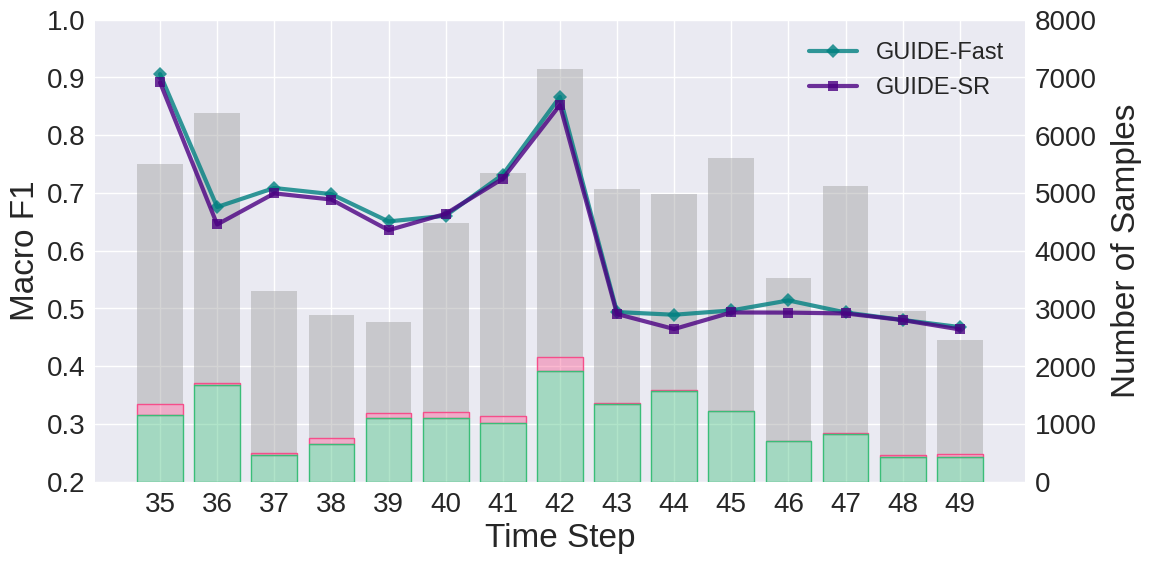

In [13]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plot_daily = {}
plot_daily['licit'] = []
plot_daily['illicit'] = []
plot_daily['unknown'] = []
for t in range(len(dataset_test)):
    plot_daily['licit'].append((dataset_test[t].y==0).sum().item())
    plot_daily['illicit'].append((dataset_test[t].y==1).sum().item())
    plot_daily['unknown'].append((dataset_test[t].y==2).sum().item())
#     print(plot_daily['illicit'][-1], (dataset_test[t].y==1).sum().item()/(dataset_test[t].y==0).sum().item())
    
plt.style.use('seaborn')
fig, axright =plt.subplots(figsize=(12, 6))
x = range(35,50)
axleft = axright.twinx()
axright.bar(x,list(np.asarray(plot_daily['unknown'] )), bottom= np.asarray(plot_daily['illicit'] )+np.asarray(plot_daily['licit'] ), 
        label='# Unknown',color=(150/256, 150/256, 150/256, 0.4))
axright.bar(x,list(np.asarray(plot_daily['illicit'] )), label='# Illicit',bottom= np.asarray(plot_daily['licit'] ), 
         color=(246/256, 78/256, 139/256, 0.4), linewidth=1, edgecolor = (246/256, 78/256, 139/256, 1.0))

axright.bar(x,list(np.asarray(plot_daily['licit'] )), 
        label='# licit',color=(58/256, 190/256, 120/256, 0.4), linewidth=1, edgecolor=(58/256, 190/256, 120/256, 1))

axright.set_ylim([0,8000])
# axright.legend(loc=(0.79, 0.75), prop={'size':17})
axright.yaxis.tick_right()
axright.set_ylabel('Number of Samples', fontsize=24, labelpad=10)
axright.yaxis.set_label_position("right")
axright.yaxis.set_tick_params(labelsize=20)
axright.set_xlabel('Time Step', fontsize=24)
axright.set_xticks(range(35,50))
axright.xaxis.set_tick_params(labelsize=20)

# axleft.plot(x,list(results_full['f1macro'][:-1].mean(axis=1)), linewidth=3.0, alpha=0.8, color="royalblue", linestyle="-", marker = 'o', label= 'Scratch')
axleft.plot(x,list(results_Fast['f1macro'][:-1].mean(axis=1)), linewidth=3.0, alpha=0.8,  color="teal", linestyle="-", marker = 'D',label= 'GUIDE-Fast')
axleft.plot(x,list(results_SR['f1macro'][:-1].mean(axis=1)), linewidth=3.0, alpha=0.8,  color="indigo", linestyle="-", marker = 's',label= 'GUIDE-SR')

axleft.legend(prop={'size':17})
# axleft.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=4, prop={'size':17})
axleft.set_ylim([0.2, 1])
axleft.yaxis.tick_left()
axleft.set_ylabel('Macro F1', fontsize=24)
axleft.yaxis.set_label_position("left")
axleft.yaxis.set_tick_params(labelsize=20)
axleft.grid()
axleft.set_xlabel('Time Step', fontsize=24)

# plt.xlabel('Macro F1 results over test time span', fontsize=20)
# plt.grid()
dataname = 'EllipticBTC'
# plt.savefig(f'logs/BTC_GIN_20_MacroF1_{dataname}.pdf', format="pdf", bbox_inches='tight')
plt.show()

    

/tmp/ipykernel_353336/141498568.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


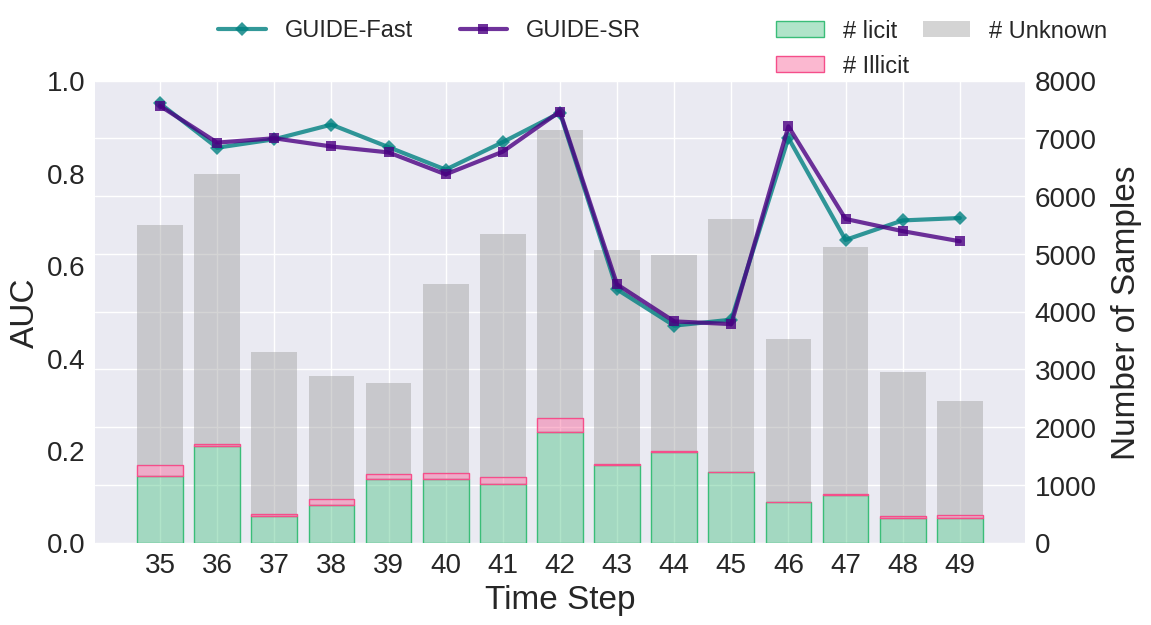

In [14]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.style.use('seaborn')
fig, axright =plt.subplots(figsize=(12, 6))
x = range(35,50)
axleft = axright.twinx()
axright.bar(x,list(np.asarray(plot_daily['licit'] )), 
        label='# licit',color=(58/256, 190/256, 120/256, 0.4), linewidth=1, edgecolor=(58/256, 190/256, 120/256, 1))
axright.bar(x,list(np.asarray(plot_daily['illicit'] )), label='# Illicit',bottom= np.asarray(plot_daily['licit'] ), 
         color=(246/256, 78/256, 139/256, 0.4), linewidth=1, edgecolor = (246/256, 78/256, 139/256, 1.0))

axright.bar(x,list(np.asarray(plot_daily['unknown'] )), bottom= np.asarray(plot_daily['illicit'] )+np.asarray(plot_daily['licit'] ), 
        label='# Unknown',color=(150/256, 150/256, 150/256, 0.4))

axright.set_ylim([0,8000])
# axright.legend(loc='best', prop={'size':17})
axright.legend(loc='upper left', bbox_to_anchor=(0.71, 1.179), ncol=2, columnspacing=0.6, prop={'size':17})

axright.yaxis.tick_right()
axright.set_ylabel('Number of Samples', fontsize=24, labelpad=10)
axright.yaxis.set_label_position("right")
axright.yaxis.set_tick_params(labelsize=20)
axright.set_xticks(range(35,50))
axright.xaxis.set_tick_params(labelsize=20)
axright.set_xlabel('Time Step', fontsize=24)

# axleft.plot(x,list(results_full['aucroc'][:-1].mean(axis=1)), linewidth=3.0, alpha=0.8,  color="royalblue", linestyle="-", marker = 'o', label= 'Scratch')
axleft.plot(x,list(results_Fast['aucroc'][:-1].mean(axis=1)), linewidth=3.0, alpha=0.8,  color="teal", linestyle="-", marker = 'D',label= 'GUIDE-Fast')
axleft.plot(x,list(results_SR['aucroc'][:-1].mean(axis=1)), linewidth=3.0, alpha=0.8,  color="indigo", linestyle="-", marker = 's',label= 'GUIDE-SR')

axleft.legend(prop={'size':17})
axleft.legend(loc='upper center', bbox_to_anchor=(0.36, 1.18), ncol=3, prop={'size':17})

axleft.set_ylim([0, 1])
axleft.yaxis.tick_left()
axleft.set_ylabel('AUC', fontsize=24)
axleft.yaxis.set_label_position("left")
axleft.yaxis.set_tick_params(labelsize=20)
axleft.grid()
axleft.set_xlabel('Time Step', fontsize=24)

# plt.savefig(f'logs/BTC_GIN_20_AUC_{dataname}.pdf', format="pdf", bbox_inches='tight')
plt.show()

    

In [24]:
torch.save(partations_fast, './checkpoints/BTC/partitions_fast_None.pt')
torch.save(partations_sr, './checkpoints/BTC/partitions_sr_None.pt')
torch.save(results_Fast, './checkpoints/BTC/results_fast_None.pt')
torch.save(results_SR, './checkpoints/BTC/results_sr_None.pt')